## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

import xgboost as xgb # xgb.XGBClassifier
import warnings

#### Import the CSV Data as Pandas DataFrame

In [2]:
df = pd.read_csv('../artifacts/data.csv')
df = df.loc[df.train_score == "train"].drop(["rounds_left", "GW", 'id', 'team_h', 'team_a', 'train_score', 'label_X', 'label_2'], axis=1)
df['season_start_year'] = df['season_start_year'].astype(str)

#### Preparing X and Y variables

In [3]:
X = df.drop(columns=['label_1'],axis=1)

In [4]:
y = df['label_1']

In [5]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [6]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((1142, 25), (286, 25))

In [7]:
X_train = preprocessor.fit_transform(X_train)
X_test  = preprocessor.transform(X_test)

In [8]:
X_train.shape, X_test.shape

((1142, 76), (286, 76))

#### Create an Evaluate Function to give all metrics after model Training

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc

import matplotlib
import matplotlib.pyplot as plt

def evaluate_model_kpi(model, X_train, y_train, X_val, y_val, threshold=0.5, model_name=None):
    ''' Write about the meaning of each metric. '''   

    if model_name == None:
        model_name = type(model)
    
    # Make predictions using the model and the DataFrame
    y_train_pred = (model.predict_proba(X_train)[:,1] >= threshold).astype(bool)
    y_val_pred = (model.predict_proba(X_val)[:,1] >= threshold).astype(bool)
    
    y_train_prob = model.predict_proba(X_train)[:,1]
    y_val_prob = model.predict_proba(X_val)[:,1]
    
    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_val = accuracy_score(y_val, y_val_pred)
    
    # Calculate precision, recall, and f1 score
    prf_train = precision_recall_fscore_support(y_train, y_train_pred, average=None)
    prf_val = precision_recall_fscore_support(y_val, y_val_pred, average=None)
    
    # Calculate area under the curve
    auc_train = roc_auc_score(y_train, y_train_prob)
    auc_val = roc_auc_score(y_val, y_val_prob)
    
    # Calculate area under the precision-recall curve
    precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred)
    auc_precision_recall_train = auc(recall_train, precision_train)
    
    precision_val, recall_val, thresholds_train = precision_recall_curve(y_val, y_val_prob)
    auc_precision_recall_val = auc(recall_val, precision_val)
    
    # Store the metrics in a DataFrame
    metrics = pd.DataFrame({
        'Algorithm': model_name,
         
        'AUC-ROC Train': [auc_train],
        'AUC-ROC Val': [auc_val],
        'AUC-PRC Train': [auc_precision_recall_train],
        'AUC-PRC Val': [auc_precision_recall_val],
        
        'Accuracy Train': [accuracy_train],
        'Accuracy Val': [accuracy_val],
        
        'Precision Train: 0': [prf_train[0][0]],
        'Precision Val: 0': [prf_val[0][0]],
        'Precision Train: 1': [prf_train[0][1]],
        'Precision Val: 1': [prf_val[0][1]],
        
        'Recall Train: 0': [prf_train[1][0]],
        'Recall Val: 0': [prf_val[1][0]],
        'Recall Train: 1': [prf_train[1][1]],
        'Recall Val: 1': [prf_val[1][1]],
        
        'F1-score Train: 0': [prf_train[2][0]],
        'F1-score Val: 0': [prf_val[2][0]],
        'F1-score Train: 1': [prf_train[2][1]],
        'F1-score Val: 1': [prf_val[2][1]],
    })
    
    return metrics

In [10]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": xgb.XGBClassifier(),
}

params = {
    "Decision Tree": {
        'criterion':['log_loss', 'entropy', 'gini'],
        'max_depth': [3, 5, 8, 10, 20],
        # 'splitter':['best','random'],
        # 'max_features':['sqrt','log2'],
    },
    "Random Forest":{
        'bootstrap': [True],
        'max_depth': [3, 5, 8, 10, 20],
        #'max_features': [2, 3, 5, 10, 20],
        #'min_samples_leaf': [3, 4, 5, 10, 20],
        #'n_estimators': [10, 50, 100]
    },
    "Gradient Boosting":{
        "loss":["log_loss"],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.5],
        #"min_samples_split": np.linspace(0.1, 0.5, 12),
        #"min_samples_leaf": np.linspace(0.1, 0.5, 12),
        "max_depth":[3,5,8,10,15],
        #"max_features":["log2", "sqrt"],
        #"criterion": ["friedman_mse",  "mae"],
        #"subsample":[0.5, 0.618, 0.8, 1.0],
        #"n_estimators": [10, 15, 20]
    },
    "Logistic Regression":{
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'penalty': ['l2'],
        'max_iter': [10000],
        #'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    },
    "XGBoost":{
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05], #, 0.1, 0.2, 0.5],
        #"gamma":[0.5, 1], #, 2],
        #'n_estimators': [50, 100], #, 200],
    },            
}

model_list = []
AUC_ROC_list = []
best_param = {}

for i in range(len(list(models))):
    model = list(models.values())[i]
    param = list(params.values())[i]

    grid = GridSearchCV(estimator = model, param_grid = param, cv = 3, n_jobs = -1, scoring = 'roc_auc', error_score="raise")
    grid.fit(X_train, y_train)

    best_param[list(models.keys())[i]] = grid.best_params_

    model.set_params(**grid.best_params_)
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    metric = evaluate_model_kpi(model=model, 
                                X_train=X_train, 
                                y_train=y_train, 
                                X_val=X_test, 
                                y_val=y_test, 
                                threshold=0.5,
                                model_name=list(models.keys())[i]
                                )
    
    print(list(models.keys())[i])
    print(grid.best_params_)
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- AUC-ROC: {:.4f}".format(metric['AUC-ROC Train'][0]))
    print("- AUC-PRC: {:.4f}".format(metric['AUC-PRC Train'][0]))
    print("- Accuracy: {:.4f}".format(metric['Accuracy Train'][0]))
    print("- Precision: 0: {:.4f}".format(metric['Precision Train: 0'][0]))
    print("- Precision: 1: {:.4f}".format(metric['Precision Train: 1'][0]))
    print("- Recall: 0: {:.4f}".format(metric['Recall Train: 0'][0]))
    print("- Recall: 1: {:.4f}".format(metric['Recall Train: 1'][0]))
    print("- F1-score: 0: {:.4f}".format(metric['F1-score Train: 0'][0]))
    print("- F1-score: 1: {:.4f}".format(metric['F1-score Train: 1'][0]))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- AUC-ROC: {:.4f}".format(metric['AUC-ROC Val'][0]))
    print("- AUC-PRC: {:.4f}".format(metric['AUC-PRC Val'][0]))
    print("- Accuracy: {:.4f}".format(metric['Accuracy Val'][0]))
    print("- Precision: 0: {:.4f}".format(metric['Precision Val: 0'][0]))
    print("- Precision: 1: {:.4f}".format(metric['Precision Val: 1'][0]))
    print("- Recall: 0: {:.4f}".format(metric['Recall Val: 0'][0]))
    print("- Recall: 1: {:.4f}".format(metric['Recall Val: 1'][0]))
    print("- F1-score: 0: {:.4f}".format(metric['F1-score Val: 0'][0]))
    print("- F1-score: 1: {:.4f}".format(metric['F1-score Val: 1'][0]))
    

    AUC_ROC_list.append(metric['AUC-ROC Val'][0])
    
    print('='*35)
    print('\n')

Decision Tree
{'criterion': 'gini', 'max_depth': 3}
Model performance for Training set
- AUC-ROC: 0.6788
- AUC-PRC: 0.6855
- Accuracy: 0.6489
- Precision: 0: 0.6857
- Precision: 1: 0.6004
- Recall: 0: 0.6931
- Recall: 1: 0.5920
- F1-score: 0: 0.6894
- F1-score: 1: 0.5962
----------------------------------
Model performance for Test set
- AUC-ROC: 0.5844
- AUC-PRC: 0.5353
- Accuracy: 0.5874
- Precision: 0: 0.6395
- Precision: 1: 0.5088
- Recall: 0: 0.6627
- Recall: 1: 0.4833
- F1-score: 0: 0.6509
- F1-score: 1: 0.4957


Random Forest
{'bootstrap': True, 'max_depth': 5}
Model performance for Training set
- AUC-ROC: 0.8128
- AUC-PRC: 0.7611
- Accuracy: 0.7242
- Precision: 0: 0.6926
- Precision: 1: 0.8157
- Recall: 0: 0.9159
- Recall: 1: 0.4780
- F1-score: 0: 0.7887
- F1-score: 1: 0.6028
----------------------------------
Model performance for Test set
- AUC-ROC: 0.6440
- AUC-PRC: 0.5674
- Accuracy: 0.6364
- Precision: 0: 0.6384
- Precision: 1: 0.6290
- Recall: 0: 0.8614
- Recall: 1: 0.325

### Results

In [26]:
pd.DataFrame(list(zip(model_list, AUC_ROC_list)), columns=['Model Name', 'AUC_ROC']).sort_values(by=["AUC_ROC"],ascending=False)

,Model Name,AUC_ROC
3,Logistic Regression,0.683936
4,XGBoost,0.658534
1,Random Forest,0.639257
2,Gradient Boosting,0.627083
0,Decision Tree,0.584362


#### Plot XGBoost feature importance

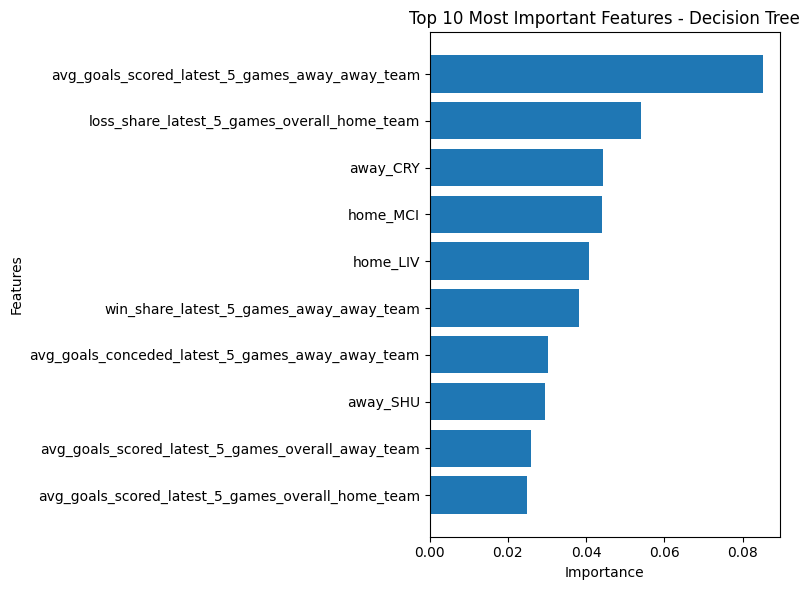

In [28]:
# Create and fit a Decision Tree classifier
clf = xgb.XGBClassifier(**best_param['XGBoost'])
clf.fit(X_train, y_train)

feature_names = preprocessor.named_transformers_['OneHotEncoder'].get_feature_names_out().tolist() + num_features.to_list()

# Get feature importance
importance = clf.feature_importances_
indices = importance.argsort()[-10:]  # Get the indices of the top 10 most important features

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])  # Use yticks instead of xticks
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.tight_layout()  # Add tight_layout to improve spacing
plt.show()

## Logistic Regression

In [15]:
best_model = LogisticRegression(**best_param['Logistic Regression'])
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, y_pred)
print("Area under the curve of the model is %.2f" %score)

Area under the curve of the model is 0.68


## Plot Confusion-matrix

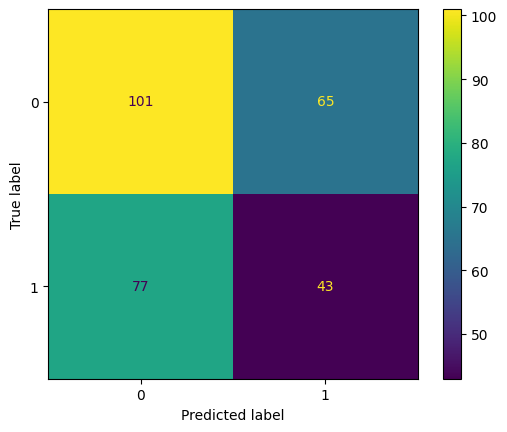

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=best_model.classes_)
disp.plot()

In [11]:
np.arange(3)

array([0, 1, 2])

In [17]:
X.iloc[[0, 1, 2]]

,season_start_year,home,away,kickoff_year,kickoff_month,win_share_latest_5_games_overall_home_team,draw_share_latest_5_games_overall_home_team,loss_share_latest_5_games_overall_home_team,avg_goals_scored_latest_5_games_overall_home_team,avg_goals_conceded_latest_5_games_overall_home_team,...,win_share_latest_5_games_home_home_team,draw_share_latest_5_games_home_home_team,loss_share_latest_5_games_home_home_team,avg_goals_scored_latest_5_games_home_home_team,avg_goals_conceded_latest_5_games_home_home_team,win_share_latest_5_games_away_away_team,draw_share_latest_5_games_away_away_team,loss_share_latest_5_games_away_away_team,avg_goals_scored_latest_5_games_away_away_team,avg_goals_conceded_latest_5_games_away_away_team
0,22,TOT,WOL,2022,8,0.5,0.5,0.0,3.0,1.5,...,1.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,1.0,2.0
1,22,CRY,AVL,2022,8,0.0,0.5,0.5,0.5,1.5,...,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0
2,22,EVE,NFO,2022,8,0.0,0.0,1.0,0.5,1.5,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
